The movie dataset that we are going to use is public and is available via the following link: https://www.kaggle.com/datasets/akkefa/movielens-9000-movies-dataset

# Link prediction on Movie lens dataset
- HeteroData builds your data structure for a multi-type graph.
- torch_geometric.transforms (T) performs graph preprocessing and augmentation before the model training phase.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import tqdm
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import string
import re
from sklearn.metrics import roc_curve,roc_auc_score,auc

In [2]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 8),
          'figure.dpi': 100,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [3]:
torch.__version__

'2.8.0+cpu'

In [4]:
movies_df = pd.read_csv("ml-latest-small/movies.csv",index_col='movieId')
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")

In [5]:
movies_df.shape

(9742, 2)

In [6]:
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings_df.shape

(100836, 4)

## number of user nodes

In [9]:
ratings_df.userId.nunique()

610

# number of movie nodes

In [10]:
ratings_df.movieId.nunique()

9724

## edge attributes

In [11]:
ratings_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

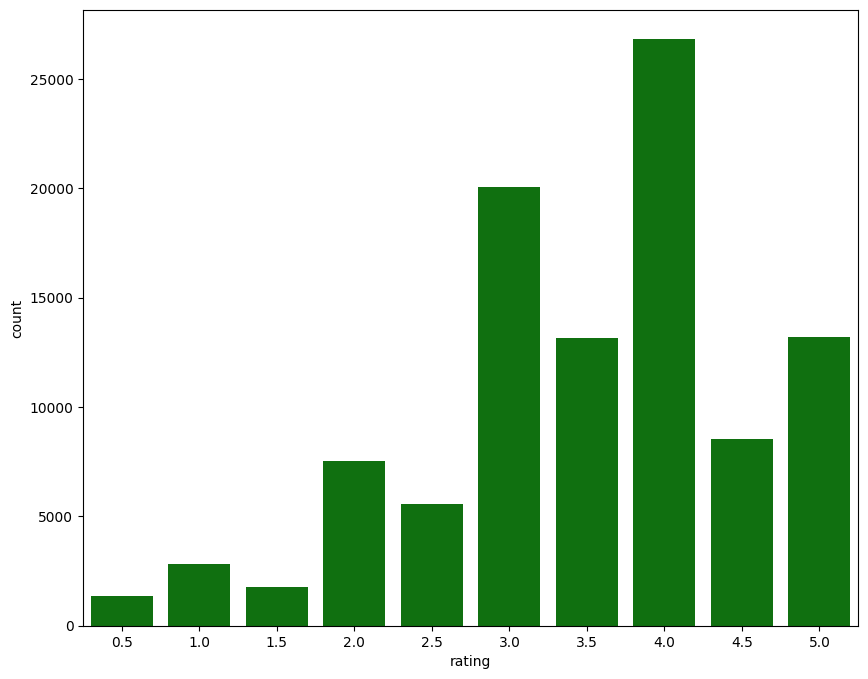

In [12]:
sns.countplot(x='rating', data=ratings_df,color="green")

## there should be 20 atributes (genres) for the movies nodes

In [13]:
# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
movie_feat.size()  # 20 genres in total.

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


torch.Size([9742, 20])

In [14]:
movie_feat[1:4]

tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]])

## create a mapping of unique user and movie ids to a range of length ids starting from 0

In [15]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()

unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()


# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(len(unique_movie_id))
print(unique_movie_id.head())

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
9724
   movieId  mappedID
0        1         0
1        3         1
2        6         2
3       47         3
4       50         4


## Perform merge to obtain the edges from users and movies:

In [16]:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')

print("ratings_user_id:")
print("===========================================")
print(ratings_user_id.head())
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)

ratings_user_id:
   userId  mappedID
0       1         0
1       1         0
2       1         0
3       1         0
4       1         0


In [17]:
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# construct our `edge_index` in COO format

In [18]:
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
print(edge_index_user_to_movie.size())
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

torch.Size([2, 100836])
Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


In [19]:
data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)



    Transductive learning: All nodes are visible during training, and only the edges are split into training, validation, and test sets. The nodes remain shared across splits, so the GNN learns embeddings for all nodes (including those appearing in test edges).

    Inductive learning: Some nodes are completely unseen during training — their embeddings are learned only during inference. RandomLinkSplit does not hide nodes; it only hides a subset of edges.

- The transform T.RandomLinkSplit in PyTorch Geometric is a transductive split method

In [20]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,                     # 10% of all edges will be used for the validation set.
    num_test=0.1,                    # 10% of all edges will be used for the test set.
    
    disjoint_train_ratio=0.3,        # 30% of training edges will be held out from message passing
                                     # and used only as supervision (ground-truth labels).
                                     # This prevents label leakage during training.

    neg_sampling_ratio=2.0,          # For every positive (real) edge, generate 2 negative edges
                                     # (nonexistent edges) for contrastive learning.
                                     # This helps the model learn to distinguish real links from fake ones.

    add_negative_train_samples=False,# If False, no negative edges are added during preprocessing.
                                     # Set this to False if your model handles its own negative sampling
                                     # during training (common in recommendation systems).

    edge_types=("user", "rates", "movie"),  # Defines which edge type to split for link prediction.
                                            # In heterogeneous graphs, this tuple identifies
                                            # edges going from 'user' nodes to 'movie' nodes
                                            # through the relation type 'rates'.

    rev_edge_types=("movie", "rev_rates", "user"), # Specifies the reverse edge type for the same relation.
                                                   # Ensures that both "user → movie" and
                                                   # "movie → user" edges are split consistently
                                                   # (important for preventing data leakage).
)

train_data, val_data, test_data = transform(data)

In [21]:
train_data["user", "rates", "movie"].edge_label, train_data["user", "rates", "movie"].edge_label.shape

(tensor([1., 1., 1.,  ..., 1., 1., 1.]), torch.Size([24201]))

In [22]:
from torch_geometric.loader import LinkNeighborLoader
# Imports the LinkNeighborLoader class, which performs neighbor sampling for link prediction tasks.
# It constructs mini-batches of subgraphs around target edges 
# (links to predict or learn from) for scalable GNN training.

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
# Extracts the indices (node pairs) of edges to predict in the training graph.
# These are the (source, target) pairs representing the “user rates movie” relationships.

print(edge_label_index, edge_label_index.shape)
# Prints the edge label index tensor and its shape (usually [2, num_edges]).
# The shape tells how many edges are used for training label prediction.

edge_label = train_data["user", "rates", "movie"].edge_label
# Retrieves the actual labels for those edges (for example, user ratings such as 1.0–5.0, or binary labels).
# These will be the target values the model tries to predict.

train_loader = LinkNeighborLoader(
    data=train_data,   # The graph data (of type HeteroData) that contains node/edge attributes and relationships.
    
    num_neighbors=[20, 10], 
    # Specifies the number of neighbors to sample per node for each GNN layer (2 layers in this example).
    # For each target edge, the loader samples 20 first-hop and 10 second-hop neighbors.
    # This controls how large the subgraph around each positive/negative edge will be.
    
    neg_sampling_ratio=2.0,
    # For every positive edge in edge_label_index, generate 2 negative edges (nonexistent links).
    # These negative samples are used to teach the model to recognize both real and fake links.

    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    # Specifies the target edge type and the corresponding indices for link prediction.
    # The first part ("user", "rates", "movie") identifies which relationship in the heterogeneous graph is being modeled.
    # The second part (edge_label_index) tells which edges will be predicted or used as seeds for mini-batching.

    edge_label=edge_label,
    # Assigns the labels (ratings) for each seed edge, enabling supervised training.

    batch_size=128,
    # Defines how many edges (samples) per mini-batch to load.
    # Each batch contains 128 positive/negative edges with their sampled subgraphs.

    shuffle=False,         # do not shuffle edges
    directed=True          # preserve directionality
)
# This creates a data loader that yields batches of subgraphs centered around the input edges.
# Each batch includes:
#   - Node features and sampled neighbors’ connections.
#   - The batch’s edge_label_index and corresponding edge_label.
# This loader enables efficient mini-batch training for large heterogeneous graphs.


tensor([[ 379,  437,  598,  ...,  413,  198,  104],
        [2232,  504,  192,  ..., 1902, 5577, 4350]]) torch.Size([2, 24201])


In [29]:
# Define the test seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,         # do not shuffle edges
    directed=True          # preserve directionality
)

# Graph Neural Network Architecture (GraphSAGE-based Link Predictor)

This model predicts **user–movie ratings** or **interactions** using a **heterogeneous Graph Neural Network (GNN)** built on **PyTorch Geometric (PyG)**.  
It has three main components:  
1. A **GraphSAGE-based encoder** (`GNN` class)  
2. A **dot-product classifier** (`Classifier` class)  
3. A **heterogeneous wrapper model** that handles users and movies (`Model` class)

***

## 1. GNN Encoder

### Code Block
```python
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor 

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
```

### Explanation
- **SAGEConv layers**: These are **GraphSAGE convolutional layers**.[2][3]
  Each performs neighbor aggregation:
  $$
  \mathbf{h}_v' = \sigma(W_1 \mathbf{h}_v + W_2 \cdot \text{mean}_{u \in \mathcal{N}(v)} \mathbf{h}_u)
  $$
  This means each node learns by aggregating information from its neighbors.

- **conv1, conv2**: Two layers refine node embeddings through iterative message passing.

- **Activation function (`ReLU`)**: Nonlinearity applied after the first layer to introduce complexity.

- **Output**: Returns updated **node embeddings** that integrate multi-hop context (neighbors of neighbors).

***

## 2. Dot-Product Classifier

### Code Block
```python
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)
```

### Explanation
- Purpose: Converts **node embeddings** into **edge (link) predictions**.
- **edge_label_index**: Contains source (`user`) and target (`movie`) node indices.  
- **Dot-product decoder**: Evaluates similarity between the user and movie embeddings:
  $$
  \hat{y}_{(u,m)} = \mathbf{h}_u \cdot \mathbf{h}_m
  $$
  Higher values imply stronger relationships (like higher ratings or link probabilities).
- The output is a scalar per edge — a prediction of interaction likelihood or rating score.

***

## 3. Full Model: Heterogeneous Link Predictor

### Code Block
```python
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Learn embeddings for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN to heterogeneous version:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        # Add final classifier:
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 

        # Perform heterogeneous message passing:
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        # Make predictions for user–movie links:
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
model = Model(hidden_channels=64)
```

### Explanation
- **Embedding layers**:
  - `user_emb`: Learns user representations from scratch (useful for cold-start scenarios).  
  - `movie_emb`: Learns movie representations; combined with linear projection (`movie_lin`) of input movie features.
- **Heterogeneous conversion**:
  - `to_hetero(self.gnn, metadata=data.metadata())` converts the base GNN to handle different node and edge types, using the dataset’s metadata.
- **Forward pass:**
  - Builds feature dictionaries (`x_dict`) for users and movies.
  - Performs message passing via the heterogeneous GNN.
  - Predicts edges using the dot-product classifier.

***

## 4. Architecture Overview

| Component | Type | Description |
|------------|------|-------------|
| SAGEConv Layer 1 | GNN Encoder | Aggregates neighbor features (GraphSAGE) |
| SAGEConv Layer 2 | GNN Encoder | Refines node embeddings |
| User Embedding | Torch Embedding | Learns user representations |
| Movie Embedding | Torch Embedding + Linear | Learns and projects movie features |
| Heterogeneous Wrapper | `to_hetero` | Adapts the model for multi-type graphs |
| Dot-Product Decoder | Classifier | Predicts link strength (e.g., user–movie rating) |

***

### Conceptually
1. **Users and movies** form nodes in a heterogeneous graph.  
2. **Ratings/interactions** represent edges connecting “user → movie.”  
3. The **GraphSAGE layers** propagate information between connected nodes.  
4. The **dot-product decoder** predicts whether (or how strongly) a user should connect to a specific movie.

In [23]:
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.nn.aggr import MLPAggregation
import torch.nn.functional as F
from torch import nn
from torchinfo import summary
from torch import Tensor

In [30]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
model = Model(hidden_channels=64)

In [25]:
# visualize the architecture
summary(model, depth=3)

Layer (type:depth-idx)                        Param #
Model                                         --
├─Linear: 1-1                                 1,344
├─Embedding: 1-2                              39,040
├─Embedding: 1-3                              623,488
├─GraphModule: 1-4                            --
│    └─ModuleDict: 2-1                        --
│    │    └─SAGEConv: 3-1                     8,256
│    │    └─SAGEConv: 3-2                     8,256
│    └─ModuleDict: 2-2                        --
│    │    └─SAGEConv: 3-3                     8,256
│    │    └─SAGEConv: 3-4                     8,256
├─Classifier: 1-5                             --
Total params: 696,896
Trainable params: 696,896
Non-trainable params: 0

# Improvement to the normal GraphSage layer
- In GraphSAGE, the **aggregation step** determines how a node combines information from its neighbors. By default, PyTorch Geometric’s `SAGEConv` uses **mean aggregation**, but you can replace it with an **MLP-based aggregator** to make the model more expressive.
> Use PyG’s `MLPAggregation`
PyTorch Geometric supports MLP aggregators directly starting from **v2.3+**, through the `MLPAggregation` or `MLPAggr` class. By inject it into `SAGEConv` via the `aggr` argument.

In [26]:
# Custom GraphSAGE layer with MLP aggregation
class MLPGraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Define MLP-based aggregator with explicit parameters
        self.mlp_aggr = MLPAggregation(
            in_channels=hidden_channels,      # per‑node input feature size
            out_channels=hidden_channels,     # output feature size
            hidden_channels=hidden_channels,  # size of hidden layer in the MLP
            num_layers=2,                     # total MLP layers
            dropout=0.1,
            max_num_elements=64
        )
        # MLPAggregation performs learnable aggregation using a small internal MLP that combines neighbor messages nonlinearly.
        # It is not permutation invariant by default (order-sensitive), so we must ensure that graph’s edge_index is sorted by destination nodes if required.

        # Create SAGE layers using that aggregator
        self.conv1 = SAGEConv(hidden_channels, hidden_channels, aggr=self.mlp_aggr)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.mlp_aggr)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class MLPModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = MLPGraphSAGE(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
mlp_model = MLPModel(hidden_channels=64)
print(mlp_model)

MLPModel(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
    )
    (mlp_aggr): MLPAggregation(64, 64, max_num_elements=64)
  )
  (classifier): Classifier()
)


**Explanation**
- `MLPAggr` replaces the mean aggregation inside GraphSAGE with an **MLP that learns how to combine neighbor features**.
- This allows the model to **learn complex non-linear interactions** among neighbors instead of taking their arithmetic mean.
- You can customize its hidden size, activation, and number of hidden layers.
- MLPAggregation is not permutation-invariant, meaning that the result depends on the order of the neighbors during aggregation.
- For a bipartite user–movie graph, the order of edges (neighbor list) is generally arbitrary, so we must ensure proper handling to avoid introducing noise in your message passing process.
- MLPAggregation flattens all neighbor features in their given order before processing them through an MLP.
If the neighbor order is inconsistent (for the same node across runs), the model could:
- it’s essential to provide deterministic, ordered input to the aggregator.
- When using loaders (like LinkNeighborLoader), we can force deterministic sampling, `shuffle=False`

In [27]:
# visualize the architecture
summary(mlp_model, depth=3)

Layer (type:depth-idx)                                       Param #
MLPModel                                                     --
├─Linear: 1-1                                                1,344
├─Embedding: 1-2                                             39,040
├─Embedding: 1-3                                             623,488
├─GraphModule: 1-4                                           --
│    └─ModuleDict: 2-1                                       --
│    │    └─SAGEConv: 3-1                                    274,752
│    │    └─SAGEConv: 3-2                                    274,752
│    └─ModuleDict: 2-2                                       --
│    │    └─SAGEConv: 3-3                                    274,752
│    │    └─SAGEConv: 3-4                                    274,752
│    └─MLPAggregation: 2-3                                   --
│    │    └─MLP: 3-5                                         266,496
├─Classifier: 1-5                                            -

## drop on graph sage layer to see the changes in performance

In [62]:
# Custom GraphSAGE layer with MLP aggregation
class MLPGraphSAGE_SingleLayer(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Define MLP-based aggregator with explicit parameters
        self.mlp_aggr = MLPAggregation(
            in_channels=hidden_channels,      # per‑node input feature size
            out_channels=hidden_channels,     # output feature size
            hidden_channels=hidden_channels,  # size of hidden layer in the MLP
            num_layers=2,                     # total MLP layers
            dropout=0.1,
            max_num_elements=64
        )
        # MLPAggregation performs learnable aggregation using a small internal MLP that combines neighbor messages nonlinearly.
        # It is not permutation invariant by default (order-sensitive), so we must ensure that graph’s edge_index is sorted by destination nodes if required.

        # Create SAGE layers using that aggregator
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.mlp_aggr)

    def forward(self, x, edge_index):
        x = self.conv2(x, edge_index)
        return x

class MLPModelSingleLayer(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = MLPGraphSAGE_SingleLayer(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
mlp_model_single = MLPModelSingleLayer(hidden_channels=64)
print(mlp_model_single)

MLPModelSingleLayer(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=MLPAggregation(64, 64, max_num_elements=64))
    )
    (mlp_aggr): MLPAggregation(64, 64, max_num_elements=64)
  )
  (classifier): Classifier()
)


In [67]:
# visualize the architecture
summary(mlp_model_single, depth=3)

Layer (type:depth-idx)                                       Param #
MLPModelSingleLayer                                          --
├─Linear: 1-1                                                1,344
├─Embedding: 1-2                                             39,040
├─Embedding: 1-3                                             623,488
├─GraphModule: 1-4                                           --
│    └─ModuleDict: 2-1                                       --
│    │    └─SAGEConv: 3-1                                    274,752
│    │    └─SAGEConv: 3-2                                    274,752
│    └─MLPAggregation: 2-2                                   --
│    │    └─MLP: 3-3                                         266,496
├─Classifier: 1-5                                            --
Total params: 1,479,872
Trainable params: 1,479,872
Non-trainable params: 0

- The function `F.binary_cross_entropy_with_logits()` (also known as **BCE with logits**) is used instead of `F.binary_cross_entropy()` because it provides **better numerical stability** and convenience when your model outputs **raw logits** (unbounded values, not probabilities).  
***

### 1. What a “logit” is
A **logit** is a raw score before applying the sigmoid function.  
For example, if your model produces outputs in the range (-18, 5), those are logits.  

To convert them into probabilities, you apply the sigmoid function:

$$
p = \sigma(x) = \frac{1}{1 + e^{-x}}
$$
- Large positive logits → probability near 1  
- Large negative logits → probability near 0

`binary_cross_entropy_with_logits` automatically performs this sigmoid operation internally and computes:

$$
\text{BCEWithLogits}(x, y)
= - \big[y \cdot \log(\sigma(x)) + (1 - y) \cdot \log(1 - \sigma(x))\big]
$$

***

### In the context of your GNN
- Your model predicts edge similarity scores as raw numbers (logits).  
- These logits go directly into `binary_cross_entropy_with_logits`, where the loss function converts them to probabilities internally and compares to target labels (0 or 1).

This approach:
- Simplifies your code (no explicit sigmoid step)
- Improves numerical stability
- Is optimized for GPU training performance in PyTorch

## Train simple graph sage model

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store the average losses for each epoch
train_losses = []
val_losses = []

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    # ===== TRAINING PHASE =====
    model.train()  # Enable gradient computation and dropout
    total_train_loss = total_train_examples = 0

    for sampled_data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch} [Training]"):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)
        
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        # use the loss that includes sigmoid in it as default
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.detach().item() * pred.numel()
        total_train_examples += pred.numel()

    avg_train_loss = total_train_loss / total_train_examples
    train_losses.append(avg_train_loss)

    # ===== VALIDATION PHASE =====
    model.eval()  # Disable gradients for evaluation
    total_val_loss = total_val_examples = 0
    
    with torch.no_grad():
        for sampled_data in tqdm.tqdm(val_loader, desc=f"Epoch {epoch} [Validation]"):
            sampled_data = sampled_data.to(device)
            
            pred = model(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            
            val_loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            
            total_val_loss += val_loss.detach().item() * pred.numel()
            total_val_examples += pred.numel()
    
    avg_val_loss = total_val_loss / total_val_examples
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch:03d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Device: cpu


Epoch 1 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.10it/s]


Epoch 001: Train Loss = 0.4357, Val Loss = 0.3534


Epoch 2 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.96it/s]


Epoch 002: Train Loss = 0.3491, Val Loss = 0.3319


Epoch 3 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 003: Train Loss = 0.3253, Val Loss = 0.3181


Epoch 4 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.95it/s]


Epoch 004: Train Loss = 0.3083, Val Loss = 0.3079


Epoch 5 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.66it/s]

Epoch 005: Train Loss = 0.2962, Val Loss = 0.3025


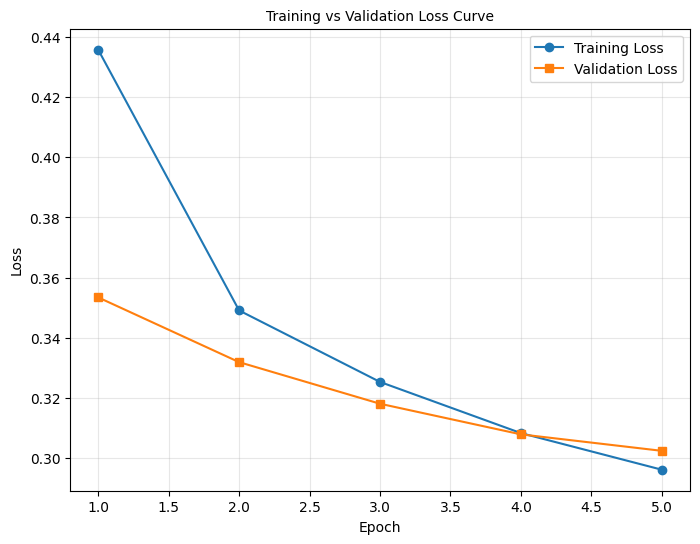

In [33]:
# ===== Visualization =====
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- as you can see in the plot after 4 epochs we must do a early stopping at 5 as it tends to overfit

## Training the improved Graph sage model (with mlp aggregation)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

mlp_model = mlp_model.to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

# Lists to store the average losses for each epoch
train_losses = []
val_losses = []

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    # ===== TRAINING PHASE =====
    mlp_model.train()  # Enable gradient computation and dropout
    total_train_loss = total_train_examples = 0

    for sampled_data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch} [Training]"):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)
        
        pred = mlp_model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        # use the loss that includes sigmoid in it as default
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.detach().item() * pred.numel()
        total_train_examples += pred.numel()

    avg_train_loss = total_train_loss / total_train_examples
    train_losses.append(avg_train_loss)

    # ===== VALIDATION PHASE =====
    mlp_model.eval()  # Disable gradients for evaluation
    total_val_loss = total_val_examples = 0
    
    with torch.no_grad():
        for sampled_data in tqdm.tqdm(val_loader, desc=f"Epoch {epoch} [Validation]"):
            sampled_data = sampled_data.to(device)
            
            pred = mlp_model(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            
            val_loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            
            total_val_loss += val_loss.detach().item() * pred.numel()
            total_val_examples += pred.numel()
    
    avg_val_loss = total_val_loss / total_val_examples
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch:03d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Device: cpu


Epoch 1 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.00it/s]


Epoch 001: Train Loss = 0.3928, Val Loss = 0.4023


Epoch 2 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.05it/s]


Epoch 002: Train Loss = 0.3421, Val Loss = 0.3563


Epoch 3 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.07it/s]


Epoch 003: Train Loss = 0.3244, Val Loss = 0.3297


Epoch 4 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:23<00:00,  3.33it/s]


Epoch 004: Train Loss = 0.3128, Val Loss = 0.3314


Epoch 5 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.78it/s]


Epoch 005: Train Loss = 0.3006, Val Loss = 0.3253


Epoch 6 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch 006: Train Loss = 0.2895, Val Loss = 0.3128


Epoch 7 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch 007: Train Loss = 0.2806, Val Loss = 0.3204


Epoch 8 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.04it/s]


Epoch 008: Train Loss = 0.2702, Val Loss = 0.3097


Epoch 9 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.93it/s]


Epoch 009: Train Loss = 0.2584, Val Loss = 0.3161


Epoch 10 [Validation]: 100%|███████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.86it/s]

Epoch 010: Train Loss = 0.2483, Val Loss = 0.3140


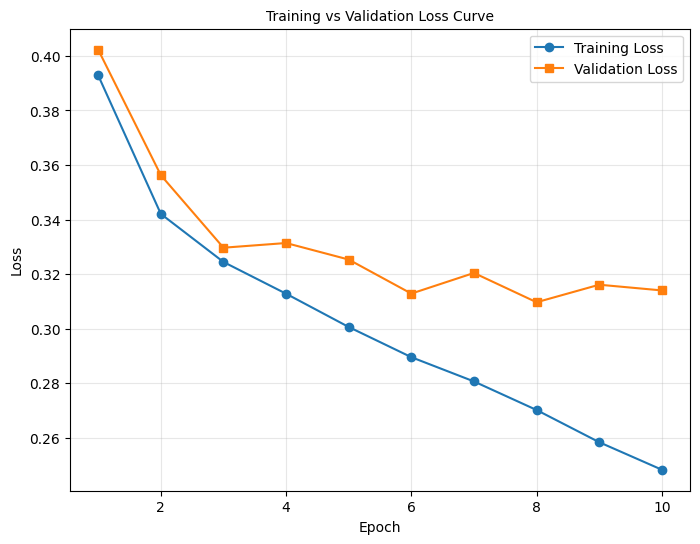

In [35]:
# ===== Visualization =====
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- as you can see in the plot after 9 epochs we must do a early stopping at 10 as it tends to overfit

## Train single layered graphsage model

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

mlp_model_single = mlp_model_single.to(device)
optimizer = torch.optim.Adam(mlp_model_single.parameters(), lr=0.001)

# Lists to store the average losses for each epoch
train_losses = []
val_losses = []

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    # ===== TRAINING PHASE =====
    mlp_model_single.train()  # Enable gradient computation and dropout
    total_train_loss = total_train_examples = 0

    for sampled_data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch} [Training]"):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)
        
        pred = mlp_model_single(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        # use the loss that includes sigmoid in it as default
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.detach().item() * pred.numel()
        total_train_examples += pred.numel()

    avg_train_loss = total_train_loss / total_train_examples
    train_losses.append(avg_train_loss)

    # ===== VALIDATION PHASE =====
    mlp_model_single.eval()  # Disable gradients for evaluation
    total_val_loss = total_val_examples = 0
    
    with torch.no_grad():
        for sampled_data in tqdm.tqdm(val_loader, desc=f"Epoch {epoch} [Validation]"):
            sampled_data = sampled_data.to(device)
            
            pred = mlp_model_single(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            
            val_loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            
            total_val_loss += val_loss.detach().item() * pred.numel()
            total_val_examples += pred.numel()
    
    avg_val_loss = total_val_loss / total_val_examples
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch:03d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Device: cpu


Epoch 1 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.31it/s]


Epoch 001: Train Loss = 0.7269, Val Loss = 0.5526


Epoch 2 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.31it/s]


Epoch 002: Train Loss = 0.4499, Val Loss = 0.4865


Epoch 3 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19it/s]


Epoch 003: Train Loss = 0.3923, Val Loss = 0.4367


Epoch 4 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.12it/s]


Epoch 004: Train Loss = 0.3738, Val Loss = 0.4242


Epoch 5 [Validation]: 100%|████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.21it/s]

Epoch 005: Train Loss = 0.3491, Val Loss = 0.4149


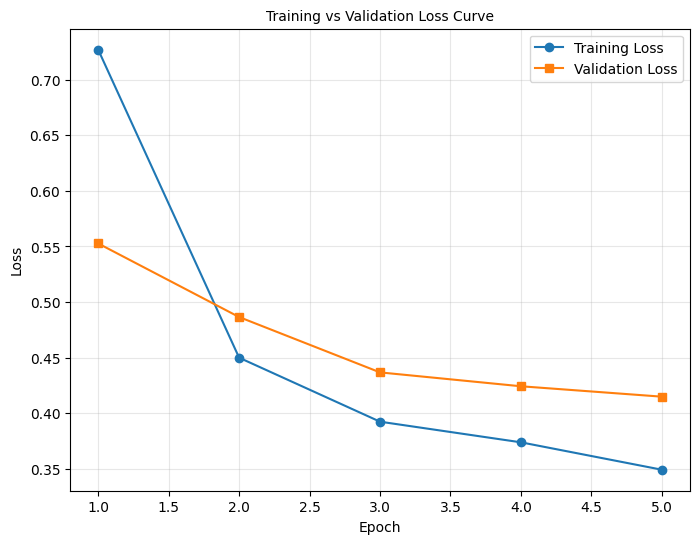

In [64]:
# ===== Visualization =====
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [36]:
# Define the test seed edges:
edge_label_index = test_data["user", "rates", "movie"].edge_label_index
edge_label = test_data["user", "rates", "movie"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,         # do not shuffle edges
    directed=True          # preserve directionality
)
sampled_data = next(iter(test_loader))

In [74]:
sampled_data

HeteroData(
  user={
    node_id=[608],
    n_id=[608],
  },
  movie={
    node_id=[2655],
    x=[2655, 20],
    n_id=[2655],
  },
  (user, rates, movie)={
    edge_index=[2, 19132],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[19132],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7745],
    e_id=[7745],
  }
)

In [75]:
import torch_geometric.utils as tg_utils
import networkx as nx

to_homogeneous() merges:

    All node types into a single unified node set.

    All edges into a single edge_index.

Each node and edge still carries its original type internally via attributes (node_type, edge_type).

In [76]:
# Convert heterogeneous graph to a homogeneous format
homo_data = sampled_data.to_homogeneous()

In [77]:
G = tg_utils.to_networkx(homo_data, to_undirected=True)

In [78]:
# Define node colors manually, based on known counts
num_user = sampled_data["user"].num_nodes
num_movie = sampled_data["movie"].num_nodes

node_colors = ["red"] * num_user + ["blue"] * num_movie

# Ensure that the number of colors matches the node count in the graph
print("Number of nodes:", len(G.nodes))
print("Number of colors:", len(node_colors))

Number of nodes: 3263
Number of colors: 3263


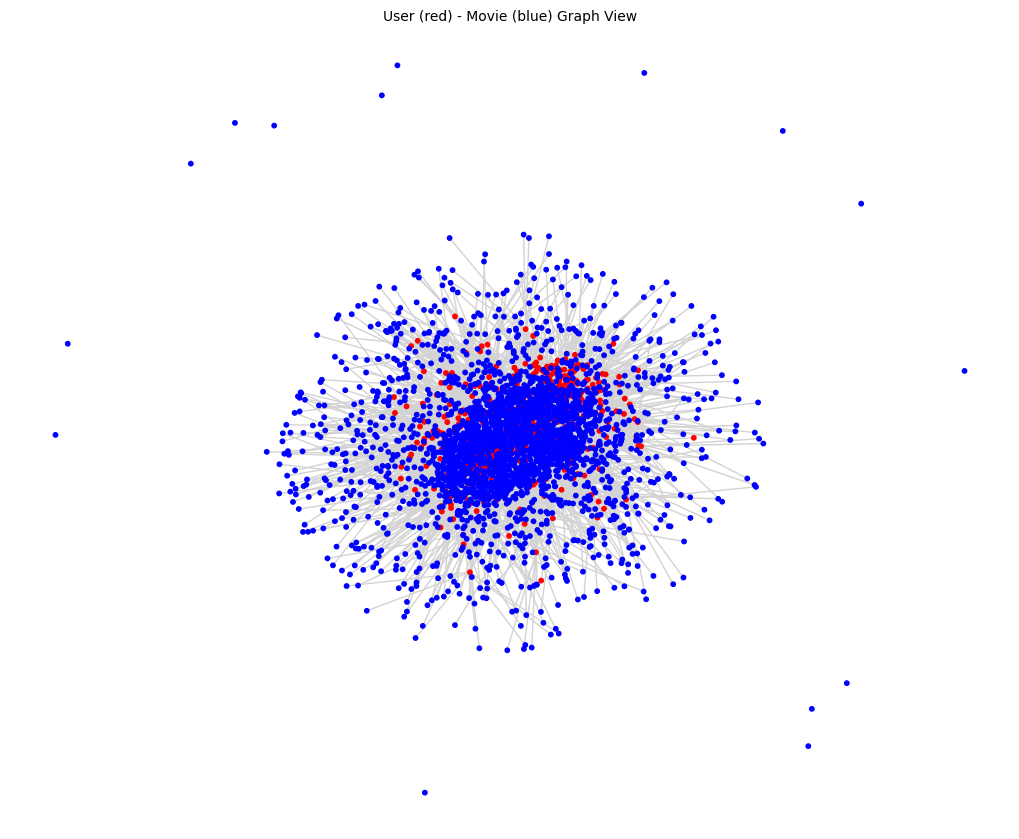

In [79]:
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    node_color=node_colors,
    node_size=10,
    edge_color="lightgray",
    with_labels=False
)
plt.title("User (red) - Movie (blue) Graph View")
plt.show()

# Evaluation:
**ground truth labels** are binary (0 and 1), while **predictions (`pred`) are logits**,

***

## Predictions Are Float Values

model produces **raw logits**, not probabilities.

- In my architecture, the **classifier** outputs:
  ```python
  return (edge_feat_user * edge_feat_movie).sum(dim=-1)
  ```
  This is a **dot product** between user and movie embeddings.
- The result is an **unbounded scalar**, meaning its values can range from negative to positive numbers (e.g., -18 to 5).
- These numbers represent **relative affinity**:
  - Large positive → strong prediction that edge = 1 (real user–movie link)
  - Large negative → strong prediction that edge = 0 (no link)

So these **logit scores** are suitable for AUC calculation because ROC curves are designed to rank predictions, not classify them directly.

In [38]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc_score = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc_score:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.42it/s]


Validation AUC: 0.9307


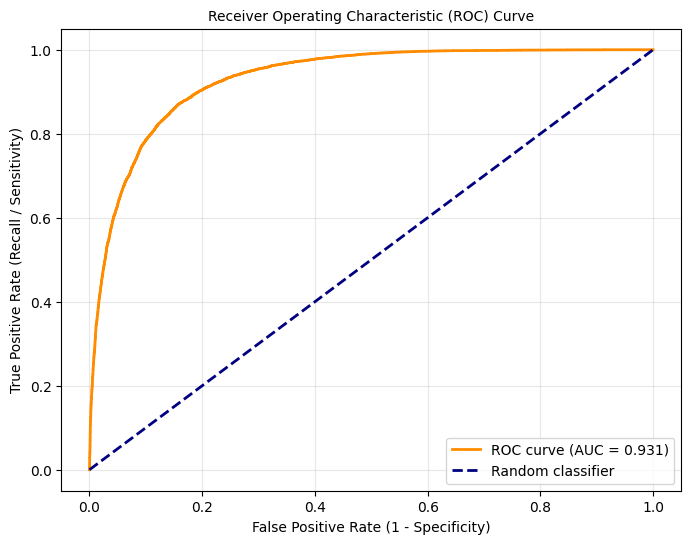

In [39]:
# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(ground_truth, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall / Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [40]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(mlp_model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc_score = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc_score:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.86it/s]


Validation AUC: 0.9271


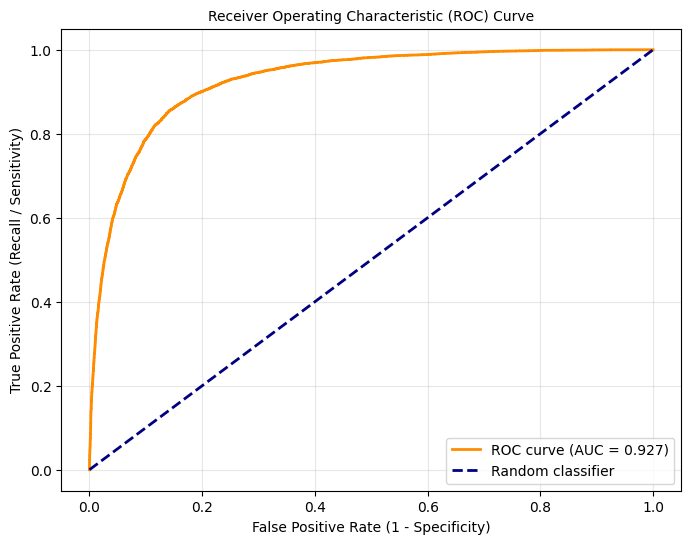

In [41]:
# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(ground_truth, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall / Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [65]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(mlp_model_single(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc_score = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc_score:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  3.97it/s]


Validation AUC: 0.8818


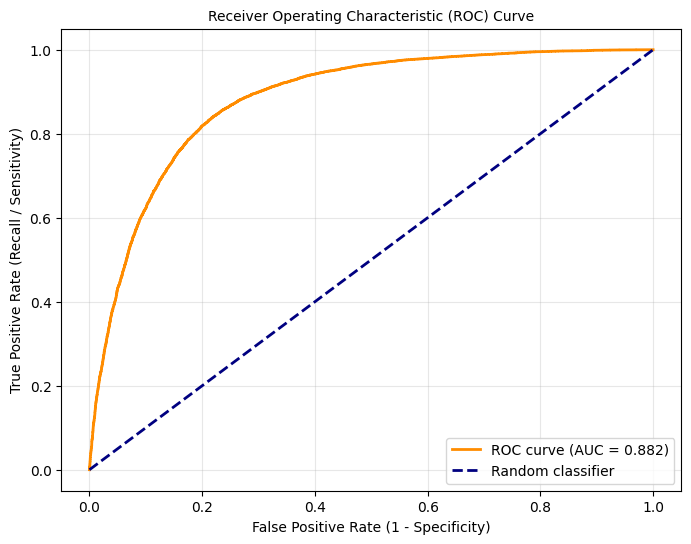

In [66]:
# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(ground_truth, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall / Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Understanding the ROC Curve

The **Receiver Operating Characteristic (ROC)** curve helps us visualize my model’s performance across all classification thresholds.

| Axis | Meaning |
|------|----------|
| **x-axis** | False Positive Rate (FPR) = proportion of negatives incorrectly classified as positives |
| **y-axis** | True Positive Rate (TPR) = proportion of positives correctly classified (Recall) |

**Each point** on the ROC curve corresponds to a specific decision threshold — how confidently the model distinguishes between the two classes.

***

### Interpreting the Curve

- **The diagonal line** (dashed) is the *random baseline* — an AUC of 0.5 corresponds to random guessing.
- **The closer the curve hugs the top-left corner**, the better your model distinguishes between positive and negative classes.
- **Area Under the Curve (AUC)** quantifies this ability:
  - **AUC = 1.0** → perfect classification.
  - **AUC = 0.7–0.9** → good model.
  - **AUC ≈ 0.5** → no discriminative power (same as random).
  - **AUC < 0.5** → model predictions are effectively inverted.

***

### Intuition from the ROC Curve

1. **Model robustness across thresholds:**  
   The ROC curve examines performance *independent of any single threshold*, showing whether the model remains reliable at various cutoffs.

2. **Trade-off visualization:**  
   Moving along the curve reveals how higher recall (TPR) often comes at the cost of more false positives (FPR).

3. **Class imbalance tolerance:**  
   Unlike accuracy, ROC curves are **not biased** by class imbalance — ideal for recommendation or link prediction tasks, where positive edges may be rare.

4. **Decision optimization:**  
   You can pick a threshold where the curve starts flattening (high TPR but low FPR increase) as an optimal operating point.

# User–Movie Similarity and Top‑10 Recommendations
### in the model, the **dot product** between the user embedding and the movie embedding is a measure of **similarity or affinity**. The higher the score, the stronger the model believes that user–movie pair is a likely match (rating = 1 or high preference).  

In [51]:
# Assume your trained model and original `data` (before splitting) are available
model.eval()
mlp_model.eval()
# Choose one random user ID (example: user with index 42)
user_id = 42

# Step 1 — Find all movies this user has rated
user_edges = data["user", "rates", "movie"].edge_index
user_rated_movies = user_edges[1][user_edges[0] == user_id].unique()

print(f"User {user_id} rated {len(user_rated_movies)} movies:")
print(user_rated_movies[:10])  # show first 10

User 42 rated 114 movies:
tensor([ 0,  1,  3,  7, 13, 16, 17, 19, 20, 21])


In [52]:
unique_movie_id.columns

Index(['movieId', 'mappedID'], dtype='object')

In [110]:
# get the real movie ids
real_movie_ids = unique_movie_id.loc[unique_movie_id["mappedID"].isin(user_rated_movies.tolist()),"movieId"]

In [113]:
real_movie_ids

0          1
1          3
3         47
7        110
13       231
        ... 
2652     259
2653     484
2654     519
2655     828
2656    1105
Name: movieId, Length: 114, dtype: int64

In [112]:
movies_df.loc[movies_df.index.isin(real_movie_ids.tolist())].reset_index()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,5,Father of the Bride Part II (1995),Comedy
3,7,Sabrina (1995),Comedy|Romance
4,8,Tom and Huck (1995),Adventure|Children
...,...,...,...
109,1064,Aladdin and the King of Thieves (1996),Animation|Children|Comedy|Fantasy|Musical|Romance
110,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
111,1084,Bonnie and Clyde (1967),Crime|Drama
112,1105,Children of the Corn IV: The Gathering (1996),Horror


# prediction for simple model

In [43]:
# Step 2 — Compute node embeddings for users and movies
with torch.no_grad():
    x_dict = {
        "user": model.user_emb(data["user"].node_id),
        "movie": model.movie_lin(data["movie"].x) + model.movie_emb(data["movie"].node_id),
    }
    x_dict = model.gnn(x_dict, data.edge_index_dict)

user_embed = x_dict["user"][user_id]
movie_embeds = x_dict["movie"]

In [44]:
# Step 3 — Compute similarity scores between this user and all movies
# (dot product similarity)
scores = torch.matmul(movie_embeds, user_embed)

In [45]:
# Step 4 — Exclude movies already seen/rated
mask = torch.ones(scores.size(0), dtype=torch.bool)
mask[user_rated_movies] = False
scores = scores[mask]

In [46]:
# Step 5 — Get Top‑10 most similar (highest‑scoring) unseen movies
topk = torch.topk(scores, k=10)
top_movie_indices = torch.arange(movie_embeds.size(0))[mask][topk.indices]

print("\nTop‑10 recommended movies for this user (highest similarity):")
for rank, idx in enumerate(top_movie_indices.tolist(), start=1):
    print(f"{rank:02d}. Movie ID {idx} — Similarity score: {topk.values[rank-1]:.4f}")


Top‑10 recommended movies for this user (highest similarity):
01. Movie ID 28 — Similarity score: 3.1306
02. Movie ID 291 — Similarity score: 2.9434
03. Movie ID 15 — Similarity score: 2.8236
04. Movie ID 4 — Similarity score: 2.7237
05. Movie ID 561 — Similarity score: 2.5439
06. Movie ID 467 — Similarity score: 2.3098
07. Movie ID 42 — Similarity score: 2.2426
08. Movie ID 492 — Similarity score: 2.2062
09. Movie ID 203 — Similarity score: 2.1645
10. Movie ID 68 — Similarity score: 2.1644


In [47]:
unique_movie_id.loc[unique_movie_id["mappedID"].isin(top_movie_indices.tolist())]

,movieId,mappedID
4,50,4
15,260,15
28,527,28
42,780,42
68,1196,68
203,3147,203
291,21,291
467,266,467
492,19,492
561,237,561


In [48]:
# get the real movie ids
real_movie_ids_recommendation = unique_movie_id.loc[unique_movie_id["mappedID"].isin(top_movie_indices.tolist()),"movieId"]

In [49]:
real_movie_ids_recommendation

4        50
15      260
28      527
42      780
68     1196
203    3147
291      21
467     266
492      19
561     237
Name: movieId, dtype: int64

In [50]:
movies_df.loc[movies_df.index.isin(real_movie_ids_recommendation.tolist())].reset_index()

,movieId,title,genres
0,19,Ace Ventura: When Nature Calls (1995),Comedy
1,21,Get Shorty (1995),Comedy|Crime|Thriller
2,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
3,237,Forget Paris (1995),Comedy|Romance
4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,266,Legends of the Fall (1994),Drama|Romance|War|Western
6,527,Schindler's List (1993),Drama|War
7,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
8,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
9,3147,"Green Mile, The (1999)",Crime|Drama


## prediction for mlp model

In [54]:
data = data.sort(sort_by_row=False)

In [55]:
# Step 2 — Compute node embeddings for users and movies
with torch.no_grad():
    x_dict = {
        "user": mlp_model.user_emb(data["user"].node_id),
        "movie": mlp_model.movie_lin(data["movie"].x) + mlp_model.movie_emb(data["movie"].node_id),
    }
    x_dict = mlp_model.gnn(x_dict, data.edge_index_dict)

user_embed = x_dict["user"][user_id]
movie_embeds = x_dict["movie"]

In [56]:
# Step 3 — Compute similarity scores between this user and all movies
# (dot product similarity)
scores = torch.matmul(movie_embeds, user_embed)

In [57]:
# Step 4 — Exclude movies already seen/rated
mask = torch.ones(scores.size(0), dtype=torch.bool)
mask[user_rated_movies] = False
scores = scores[mask]

In [58]:
# Step 5 — Get Top‑10 most similar (highest‑scoring) unseen movies
topk = torch.topk(scores, k=10)
top_movie_indices = torch.arange(movie_embeds.size(0))[mask][topk.indices]

print("\nTop‑10 recommended movies for this user (highest similarity):")
for rank, idx in enumerate(top_movie_indices.tolist(), start=1):
    print(f"{rank:02d}. Movie ID {idx} — Similarity score: {topk.values[rank-1]:.4f}")


Top‑10 recommended movies for this user (highest similarity):
01. Movie ID 636 — Similarity score: 9.1292
02. Movie ID 568 — Similarity score: 8.9312
03. Movie ID 492 — Similarity score: 8.1891
04. Movie ID 596 — Similarity score: 8.1259
05. Movie ID 647 — Similarity score: 8.1184
06. Movie ID 561 — Similarity score: 7.9738
07. Movie ID 2545 — Similarity score: 7.7768
08. Movie ID 677 — Similarity score: 7.7076
09. Movie ID 565 — Similarity score: 7.6563
10. Movie ID 559 — Similarity score: 7.5836


In [59]:
# get the real movie ids
real_movie_ids_recommendation = unique_movie_id.loc[unique_movie_id["mappedID"].isin(top_movie_indices.tolist()),"movieId"]

In [60]:
movies_df.loc[movies_df.index.isin(real_movie_ids_recommendation.tolist())].reset_index()

,movieId,title,genres
0,19,Ace Ventura: When Nature Calls (1995),Comedy
1,227,Drop Zone (1994),Action|Thriller
2,234,Exit to Eden (1994),Comedy
3,237,Forget Paris (1995),Comedy|Romance
4,248,Houseguest (1994),Comedy
5,252,I.Q. (1994),Comedy|Romance
6,315,"Specialist, The (1994)",Action|Drama|Thriller
7,440,Dave (1993),Comedy|Romance
8,485,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy
9,640,Diabolique (1996),Drama|Thriller


### Interpreting the Similarity Scores

| Range | Meaning |
|--------|----------|
| Large positive (e.g., > 3–5) | Model expects a strong user–movie affinity → likely recommendation |
| Near zero | Neutral or uncertain relationship |
| Large negative (e.g., < –3) | Model expects dislike or lack of interest |

Since my model’s dot‑product embeddings aren’t bounded (they can be negative or positive), the raw score is **relative** — it’s only meaningful for **ranking** movies for the same user, not across different users.  

This is the same principle used in **Matrix Factorization** and **GNN‑based recommenders**: similarity through latent embedding dot products predicts preference strength.


# Conclusion

- When you switch your **GraphSAGE aggregation** from the typical **mean** to an **MLP aggregator**, the **similarity scores for user–movie pairs** often become noticeably *higher* or *more variable*.  
- it reflects a real difference in how representation learning works between the two aggregation strategies.
***

## 1. Conceptual Difference in Aggregation

### Mean Aggregation
- Computes a **simple average** of neighbor features:
  $$
  h_v^{(k)} = \sigma\Big(W \cdot \text{Mean}\big(\{h_u^{(k-1)}, \forall u \in N(v)\}\big)\Big)
  $$
- It is **permutation invariant** and **linear**.
- Every neighbor contributes equally — it assumes all relationships are homogeneous and symmetric.

**Effect:**  
Embeddings become *smooth* and *uniform*, pulling connected nodes closer together in the feature space. This leads to **moderate similarity scores**, typically concentrated in a narrower range (e.g., 0.0 – 5.0).

***

### MLP Aggregation (a.k.a. Pool Aggregation)
- Combines neighbor messages via a **non-linear MLP**:
  $$
  h_v^{(k)} = \sigma\Big(W \cdot \text{MLP}\big(\{h_u^{(k-1)}\}\big)\Big)
  $$
- The MLP **learns transformations** of the neighbor features, allowing **non‑linear weighting** and **feature interactions**.
- The result depends on the *order* or *pattern* of neighbor features if they’re not permutation‑invariant.

**Effect:**  
MLP aggregation often magnifies **similarities and differences**:
- Some user–movie pairs get *much higher* scores if the MLP strongly activates on their combined features.
- Others drop sharply if the non-linear MLP output saturates near 0.

This yields greater variation and typically **higher peak similarity values**.

***

## 2. Theoretical Explanation

From the original **GraphSAGE paper** (Hamilton et al., NIPS 2017) :

> “The pooling and LSTM aggregators both outperform the mean aggregator because they capture more complex neighborhood feature distributions. Mean-based aggregation tends to underfit by averaging out key structural signals.”

In particular:
- The **MLP (or pooling) aggregator** effectively learns “importance functions” for neighbor nodes.  
- It amplifies embeddings for strong signals (e.g., a user liking a certain type of movie) and diminishes weak/noisy ones.  
- The output has **higher variance** and **stronger signal activation**, hence higher similarity magnitudes in downstream link-prediction tasks.

***